In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.2
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.0859

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - loss: 0.0643
Average validation loss: 0.6249295473098755
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - loss: 0.0643 - val_loss: 0.6249
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 503ms/step - loss: 0.0458 - val_loss: 0.6249
Average validation loss: 0.3348746597766876
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 513ms/step - loss: 0.0458 - val_loss: 0.4799
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 556ms/step - loss: 0.0342 - val_loss: 0.4799
Average validation loss: 0.18165968358516693
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 564ms/step - loss: 0.0342 - val_loss: 0.3805
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segf

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 786ms/step - loss: 3.5598e-05
Average validation loss: 0.10880382359027863
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 795ms/step - loss: 3.5598e-05 - val_loss: 0.1088
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 785ms/step - loss: 3.2928e-05 - val_loss: 0.1088
Average validation loss: 0.08615820668637753
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 795ms/step - loss: 3.2928e-05 - val_loss: 0.0975
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 846ms/step - loss: 3.1977e-05 - val_loss: 0.0975
Average validation loss: 0.13101202994585037
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 857ms/step - loss: 3.1977e-05 - val_loss: 0.1087
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 892ms/step - loss: 3.1417e-05 - val_loss: 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 785ms/step - loss: 8.7011e-06
Average validation loss: 0.04132972409327825
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 792ms/step - loss: 8.7011e-06 - val_loss: 0.0413
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 786ms/step - loss: 8.9665e-06 - val_loss: 0.0413
Average validation loss: 0.029021839300791424
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 797ms/step - loss: 8.9665e-06 - val_loss: 0.0352
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 761ms/step - loss: 8.5453e-06 - val_loss: 0.0352
Average validation loss: 0.020061645035942394
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 774ms/step - loss: 8.5453e-06 - val_loss: 0.0301
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\we

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 857ms/step - loss: 7.5348e-06
Average validation loss: 0.08979467675089836
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 867ms/step - loss: 7.5348e-06 - val_loss: 0.0898
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 850ms/step - loss: 6.3076e-06 - val_loss: 0.0898
Average validation loss: 0.010324997012503445
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 862ms/step - loss: 6.3076e-06 - val_loss: 0.0501
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 839ms/step - loss: 5.6970e-06 - val_loss: 0.0501
Average validation loss: 0.027238726848736405
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 851ms/step - loss: 5.6970e-06 - val_loss: 0.0425
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 816ms/step - loss: 5.681

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 816ms/step - loss: 3.7291e-06
Average validation loss: 0.015553815383464098
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 827ms/step - loss: 3.7291e-06 - val_loss: 0.0156
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 800ms/step - loss: 3.6952e-06 - val_loss: 0.0156
Average validation loss: 0.015024739876389503
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 811ms/step - loss: 3.6952e-06 - val_loss: 0.0153
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 797ms/step - loss: 3.3376e-06 - val_loss: 0.0153
Average validation loss: 0.00547537007369101
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 807ms/step - loss: 3.3376e-06 - val_loss: 0.0120
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\w

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 800ms/step - loss: 2.0567e-06
Average validation loss: 0.006986669691589971
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 810ms/step - loss: 2.0567e-06 - val_loss: 0.0070
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 777ms/step - loss: 1.6646e-06 - val_loss: 0.0070
Average validation loss: 0.01774431609859069
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 786ms/step - loss: 1.6646e-06 - val_loss: 0.0124
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 777ms/step - loss: 1.4261e-06 - val_loss: 0.0124
Average validation loss: 0.0035025349158483246
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 787ms/step - loss: 1.4261e-06 - val_loss: 0.0094
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_30.pth'.
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 76s 786ms/step - loss: 1.26

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 766ms/step - loss: 7.8441e-06
Average validation loss: 0.11987173594534398
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 778ms/step - loss: 7.8441e-06 - val_loss: 0.1199
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 824ms/step - loss: 5.8525e-06 - val_loss: 0.1199
Average validation loss: 0.03701568546239287
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 833ms/step - loss: 5.8525e-06 - val_loss: 0.0784
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 96s 777ms/step - loss: 4.8910e-06 - val_loss: 0.0784
Average validation loss: 0.0191010509734042
40/40 ━━━━━━━━━━━━━━━━━━━━ 96s 786ms/step - loss: 4.8910e-06 - val_loss: 0.0587
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weig

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 781ms/step - loss: 5.8514e-06
Average validation loss: 0.008010831739132604
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 791ms/step - loss: 5.8514e-06 - val_loss: 0.0080
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 74s 758ms/step - loss: 6.2808e-06 - val_loss: 0.0080
Average validation loss: 0.007219724182505161
48/48 ━━━━━━━━━━━━━━━━━━━━ 75s 769ms/step - loss: 6.2808e-06 - val_loss: 0.0076
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 112s 781ms/step - loss: 5.2751e-06 - val_loss: 0.0076
Average validation loss: 0.021218519036968548
48/48 ━━━━━━━━━━━━━━━━━━━━ 113s 793ms/step - loss: 5.2751e-06 - val_loss: 0.0121
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 150s 772ms/step - loss: 4

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 817ms/step - loss: 3.3770e-06
Average validation loss: 0.0082196228738342
56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 829ms/step - loss: 3.3770e-06 - val_loss: 0.0082
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 93s 822ms/step - loss: 2.4383e-06 - val_loss: 0.0082
Average validation loss: 0.005659150799536812
56/56 ━━━━━━━━━━━━━━━━━━━━ 93s 834ms/step - loss: 2.4383e-06 - val_loss: 0.0069
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 142s 872ms/step - loss: 1.9167e-06 - val_loss: 0.0069
Average validation loss: 0.004616780614014715
56/56 ━━━━━━━━━━━━━━━━━━━━ 143s 884ms/step - loss: 1.9167e-06 - val_loss: 0.0062
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 55s 857ms/step - loss: 1.2913e-06
Average validation loss: 0.014137074453174137
64/64 ━━━━━━━━━━━━━━━━━━━━ 56s 868ms/step - loss: 1.2913e-06 - val_loss: 0.0141
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 105s 776ms/step - loss: 1.0019e-06 - val_loss: 0.0141
Average validation loss: 0.002533091392251663
64/64 ━━━━━━━━━━━━━━━━━━━━ 106s 787ms/step - loss: 1.0019e-06 - val_loss: 0.0083
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 156s 773ms/step - loss: 8.4744e-07 - val_loss: 0.0083
Average validation loss: 0.0028247713489690796
64/64 ━━━━━━━━━━━━━━━━━━━━ 156s 784ms/step - loss: 8.4744e-07 - val_loss: 0.0065
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 207s 783ms/step - loss

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 778ms/step - loss: 1.7330e-06
Average validation loss: 0.006013123667798936
72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 790ms/step - loss: 1.7330e-06 - val_loss: 0.0060
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 779ms/step - loss: 2.2485e-06 - val_loss: 0.0060
Average validation loss: 0.024651177279237244
72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 790ms/step - loss: 2.2485e-06 - val_loss: 0.0153
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 170s 775ms/step - loss: 2.0414e-06 - val_loss: 0.0153
Average validation loss: 0.006074188264190323
72/72 ━━━━━━━━━━━━━━━━━━━━ 170s 786ms/step - loss: 2.0414e-06 - val_loss: 0.0122
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 226s 778ms/step - loss: 1.7138e-06 - val_loss: 0.0122
Average validation loss: 0.006145827103561412
72/72 ━━━━━━━━━━━━━━━━━━━━ 227s 789ms/step - loss: 1.7138e-06 - val_loss: 0.0107

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 62s 775ms/step - loss: 8.9215e-07
Average validation loss: 0.0072678783384617415
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 786ms/step - loss: 8.9215e-07 - val_loss: 0.0073
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 132s 870ms/step - loss: 6.9487e-07 - val_loss: 0.0073
Average validation loss: 0.0032891416369238867
80/80 ━━━━━━━━━━━━━━━━━━━━ 133s 881ms/step - loss: 6.9487e-07 - val_loss: 0.0053
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 206s 907ms/step - loss: 5.5792e-07 - val_loss: 0.0053
Average validation loss: 0.009125349536770955
80/80 ━━━━━━━━━━━━━━━━━━━━ 207s 918ms/step - loss: 5.5792e-07 - val_loss: 0.0066
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 269s 778ms/step - l

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 77s 798ms/step - loss: 1.5010e-05
Average validation loss: 0.01815284990395109
96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 810ms/step - loss: 1.5010e-05 - val_loss: 0.0182
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 152s 769ms/step - loss: 9.7363e-06 - val_loss: 0.0182
Average validation loss: 0.03372998785926029
96/96 ━━━━━━━━━━━━━━━━━━━━ 153s 780ms/step - loss: 9.7363e-06 - val_loss: 0.0259
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 227s 771ms/step - loss: 7.1404e-06 - val_loss: 0.0259
Average validation loss: 0.03520811464598713
96/96 ━━━━━━━━━━━━━━━━━━━━ 228s 782ms/step - loss: 7.1404e-06 - val_loss: 0.0290
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 301s 762ms/step - loss: 6.6227e-06 - val_loss: 0.0290
Average validation loss: 0.01446224752968798
96/96 ━━━━━━━━━━━━━━━━━━━━ 302s 773ms/step - loss: 6.6227e-06 - val_loss: 0.0254
Sa

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 94s 786ms/step - loss: 6.6459e-06
Average validation loss: 0.03003743885104389
120/120 ━━━━━━━━━━━━━━━━━━━━ 96s 797ms/step - loss: 6.6459e-06 - val_loss: 0.0300
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 190s 788ms/step - loss: 4.4330e-06 - val_loss: 0.0300
Average validation loss: 0.032012713517845744
120/120 ━━━━━━━━━━━━━━━━━━━━ 192s 799ms/step - loss: 4.4330e-06 - val_loss: 0.0310
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 285s 778ms/step - loss: 3.3843e-06 - val_loss: 0.0310
Average validation loss: 0.015104091176666164
120/120 ━━━━━━━━━━━━━━━━━━━━ 286s 789ms/step - loss: 3.3843e-06 - val_loss: 0.0257
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_150.pth'.
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 380s 776

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 112s 777ms/step - loss: 5.4697e-06
Average validation loss: 0.017781563604220056
144/144 ━━━━━━━━━━━━━━━━━━━━ 114s 788ms/step - loss: 5.4697e-06 - val_loss: 0.0178
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 225s 777ms/step - loss: 4.7409e-06 - val_loss: 0.0178
Average validation loss: 0.024702087015138357
144/144 ━━━━━━━━━━━━━━━━━━━━ 227s 787ms/step - loss: 4.7409e-06 - val_loss: 0.0212
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 338s 775ms/step - loss: 3.8833e-06 - val_loss: 0.0212
Average validation loss: 0.013989272743314234
144/144 ━━━━━━━━━━━━━━━━━━━━ 340s 786ms/step - loss: 3.8833e-06 - val_loss: 0.0188
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_180.pth'.
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 451s 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 125s 778ms/step - loss: 5.2776e-06
Average validation loss: 0.031784581818035916
160/160 ━━━━━━━━━━━━━━━━━━━━ 126s 789ms/step - loss: 5.2776e-06 - val_loss: 0.0318
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 251s 778ms/step - loss: 3.8423e-06 - val_loss: 0.0318
Average validation loss: 0.033480504906154354
160/160 ━━━━━━━━━━━━━━━━━━━━ 253s 789ms/step - loss: 3.8423e-06 - val_loss: 0.0326
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 379s 792ms/step - loss: 3.0032e-06 - val_loss: 0.0326
Average validation loss: 0.009638860628456314
160/160 ━━━━━━━━━━━━━━━━━━━━ 381s 802ms/step - loss: 3.0032e-06 - val_loss: 0.0250
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_200.pth'.
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 506s 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 157s 786ms/step - loss: 5.2271e-06
Average validation loss: 0.02747624614073388
200/200 ━━━━━━━━━━━━━━━━━━━━ 159s 797ms/step - loss: 5.2271e-06 - val_loss: 0.0275
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 315s 777ms/step - loss: 4.1654e-06 - val_loss: 0.0275
Average validation loss: 0.0072423558903392405
200/200 ━━━━━━━━━━━━━━━━━━━━ 317s 788ms/step - loss: 4.1654e-06 - val_loss: 0.0174
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 473s 777ms/step - loss: 3.2820e-06 - val_loss: 0.0174
Average validation loss: 0.008795387072314042
200/200 ━━━━━━━━━━━━━━━━━━━━ 475s 788ms/step - loss: 3.2820e-06 - val_loss: 0.0145
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 632s 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 190s 792ms/step - loss: 4.4168e-06
Average validation loss: 0.01019512140774168
240/240 ━━━━━━━━━━━━━━━━━━━━ 193s 803ms/step - loss: 4.4168e-06 - val_loss: 0.0102
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 378s 773ms/step - loss: 3.2894e-06 - val_loss: 0.0102
Average validation loss: 0.008580463420366868
240/240 ━━━━━━━━━━━━━━━━━━━━ 381s 784ms/step - loss: 3.2894e-06 - val_loss: 0.0094
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 567s 776ms/step - loss: 2.7738e-06 - val_loss: 0.0094
Average validation loss: 0.00799806138384156
240/240 ━━━━━━━━━━━━━━━━━━━━ 570s 787ms/step - loss: 2.7738e-06 - val_loss: 0.0089
Saved model weights to 'c:\天_11157065\git\Rippl

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.13034388475120068, 0.08666766347363591, 0.0405384793675815, 0.016154808741412126, 0.00884603123459965, 0.009000773396110162, 0.06542958705080673, 0.021097159441560508, 0.015056556093789237, 0.012692613360486575, 0.009440077831580612, 0.010937032201269174, 0.03433723992323698, 0.01967747674652158, 0.037085096996668954, 0.03149928660963011, 0.019036011335721695, 0.008222784519531567]
std_val_losses =  [0.1271075852702131, 0.06999954309559647, 0.06809031656331749, 0.014534462417160625, 0.006648033174756643, 0.009460541407674536, 0.12360834092392037, 0.03758202340857308, 0.020446311543234716, 0.045248308016581695, 0.01025609881560924, 0.015211542841202276, 0.07116960665191299, 0.03071606941957401, 0.041813783445894974, 0.04331481766880948, 0.024207376535205275, 0.006857694744760957]


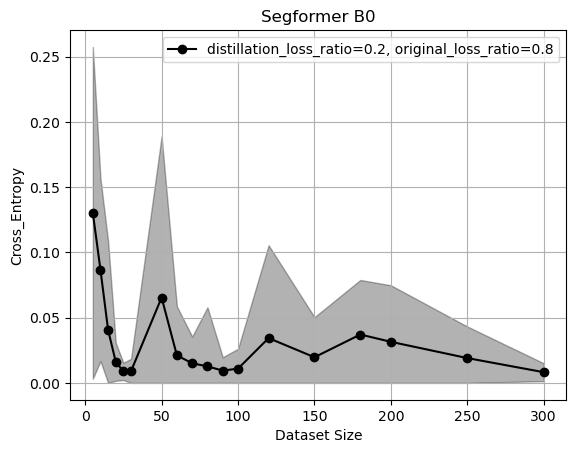

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()